# 多项式回归

In [1]:
import numpy as np


np.random.seed(42)
m = 100
x = 6 * np.random.rand(m,1) -3
y = 0.5*x**2 + x + 2 + np.random.randn(m,1)
x_new = np.linspace(-3,3,100).reshape(100,1)

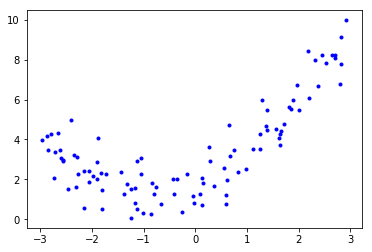

In [3]:
import matplotlib.pyplot as plt

plt.plot(x,y,'b.')
plt.show()

In [4]:
from sklearn.preprocessing import PolynomialFeatures

poly_features = PolynomialFeatures(degree=2, include_bias=False)
x_poly = poly_features.fit_transform(x)

In [5]:
x[0], x_poly[0]

(array([-0.75275929]), array([-0.75275929,  0.56664654]))

In [6]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(x_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([1.78134581]), array([[0.93366893, 0.56456263]]))

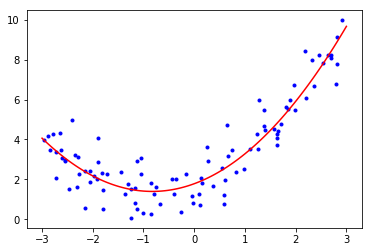

In [7]:

y_reg = 0.56456263*x_new**2 + 0.93366893*x_new + 1.78134581

# 数据点
plt.plot(x,y, 'b.')
# 模型曲线
plt.plot(x_new, y_reg, 'r-')
plt.show()

# 学习曲线

In [8]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, x, y):
    x_train, x_val, y_train, y_val = train_test_split(x,y,test_size=0.2, random_state=10)
    train_errors, val_errors = [], []
    for m in range(1,len(x_train)):
        model.fit(x_train[:m], y_train[:m])
        y_train_predict = model.predict(x_train[:m])
        y_val_predict = model.predict(x_val)
        train_errors.append(mean_squared_error(y_train_predict, y_train[:m]))
        val_errors.append(mean_squared_error(y_val_predict, y_val))
        
    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend()
    plt.axis([0, 80, 0, 3]) 
    plt.show()

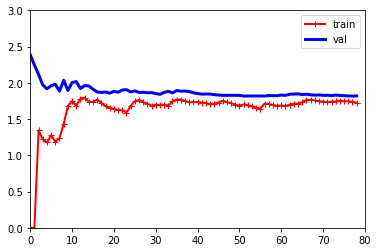

In [9]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
plot_learning_curves(lin_reg, x, y)

# 这条学习曲线是典型的模型拟合不足。 两条曲线均到达高地， 非常接近， 而且相当高。

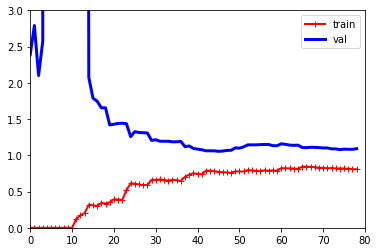

In [10]:
from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline((
    ('Poly_feature',PolynomialFeatures(degree=10,include_bias=False)),
    ('sgd_reg',LinearRegression())
))

plot_learning_curves(polynomial_regression,x,y)

# 两条曲线之间有一定差距。 这意味着该模型在训练数据上的表现比验证集上要好很多， 这正是过度拟合的标志。 
# 但是， 如果你使用更大的训练集， 那么这两条曲线将会越来越近。

# 正则线性模型

**岭回归**

公式4-8： 岭回归成本函数
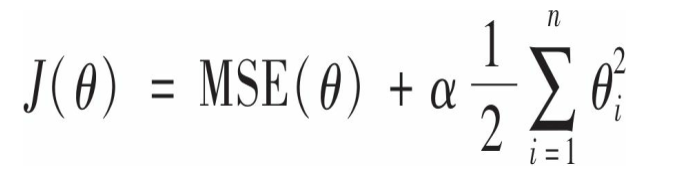

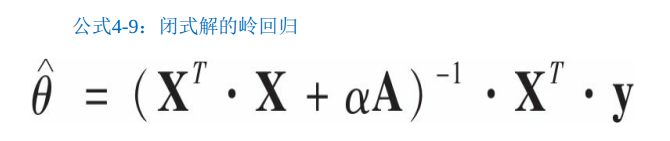

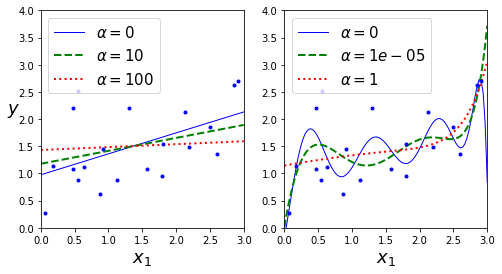

In [11]:
from sklearn.linear_model import Ridge,SGDRegressor
from sklearn.preprocessing import StandardScaler

np.random.seed(42)
m = 20
x = 3 * np.random.rand(m, 1)
y = 1 + 0.5 * x + np.random.randn(m, 1) / 1.5
x_new = np.linspace(0, 3, 100).reshape(100, 1)

def plot_model(model_class, polynomial, alphas, **model_kargs):
    for alpha, style in zip(alphas, ("b-", "g--", "r:")):
        model = model_class(alpha, **model_kargs) if alpha > 0 else LinearRegression()
        if polynomial:
            model = Pipeline([
                    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
                    ("std_scaler", StandardScaler()),
                    ("regul_reg", model),
                ])
        model.fit(x, y)
        y_new_regul = model.predict(x_new)
        lw = 2 if alpha > 0 else 1
        plt.plot(x_new, y_new_regul, style, linewidth=lw, label=r"$\alpha = {}$".format(alpha))
    plt.plot(x, y, "b.", linewidth=3)
    plt.legend(loc="upper left", fontsize=15)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 3, 0, 4])

plt.figure(figsize=(8,4))
plt.subplot(121)
plot_model(Ridge, polynomial=False, alphas=(0, 10, 100), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Ridge, polynomial=True, alphas=(0, 10**-5, 1), random_state=42)

plt.show()


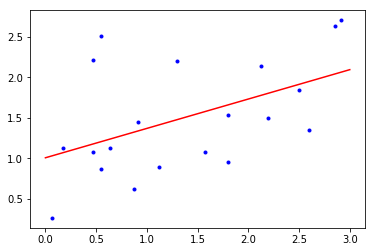

In [12]:

# 使用的是公式4-9的一种变体， 利用André-Louis Cholesky的矩阵因式分解法
ridge_reg = Ridge(alpha=1, solver="cholesky", random_state=42)
ridge_reg.fit(x,y)
# ridge_reg.predict([[1.5]])
y_pred = ridge_reg.predict(x_new)

plt.plot(x,y,'b.')
plt.plot(x_new,y_pred,'r-')
plt.show()

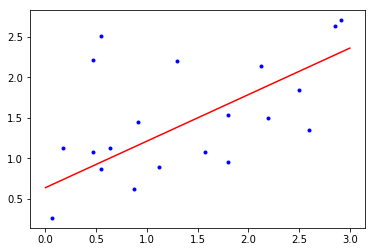

In [13]:
# 超参数penalty设置的是使用正则项的类型。 设为"l2"表示希望SGD在成本函数中添加一个正则项， 等于权重向量的l2范数的平方的一半， 即岭回归
sgd_reg = SGDRegressor(max_iter=50, tol=-np.infty, penalty="l2", random_state=42)
sgd_reg.fit(x,y.ravel())
# sgd_reg.predict([[1.5]])
y_pred = sgd_reg.predict(x_new)

plt.plot(x,y,'b.')
plt.plot(x_new,y_pred,'r-')
plt.show()

**套索回归**

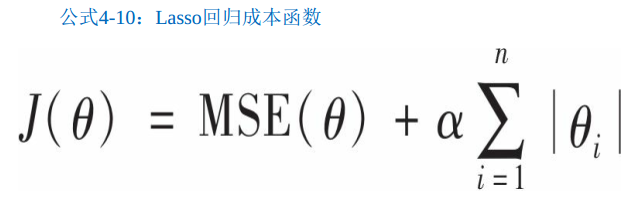

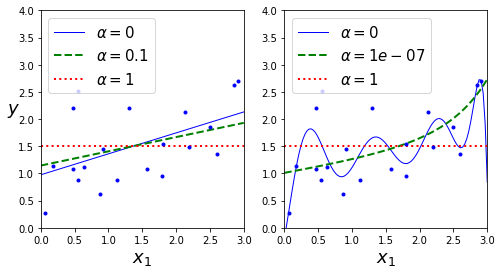

In [14]:
# 与岭回归一样， 它也是向成本函数增加一个正则项， 但是它增加的是权重向量的l1范数， 而不是l2范数的平方的一半
# Lasso回归的一个重要特点是它倾向于完全消除掉最不重要特征的权重（也就是将它们设置为零）

from sklearn.linear_model import Lasso

plt.figure(figsize=(8,4))
plt.subplot(121)
plot_model(Lasso, polynomial=False, alphas=(0, 0.1, 1), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Lasso, polynomial=True, alphas=(0, 10**-7, 1), tol=1, random_state=42)

plt.show()

公式4-11： Lasso回归次梯度向量
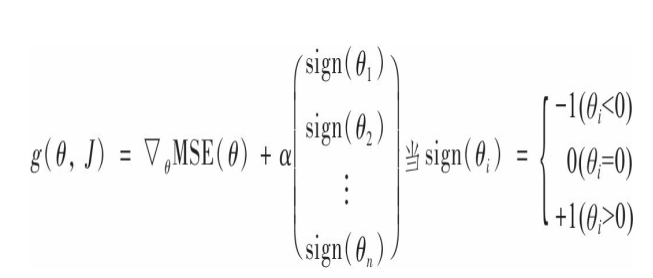

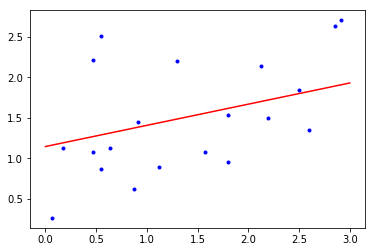

In [17]:
from sklearn.linear_model import Lasso

lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(x,y)
# lasso_reg.predict([[1.5]])
y_pred = lasso_reg.predict(x_new)

plt.plot(x,y,'b.')
plt.plot(x_new,y_pred,'r-')

**弹性网络**


In [ ]:
# 弹性网络是岭回归与Lasso回归之间的中间地带。 
# 其正则项就是岭回归和Lasso回归的正则项的混合， 混合比例通过r来控制。 
# 当r＝0时， 弹性网络即等同于岭回归， 而当r＝1时， 即相当于Lasso回归

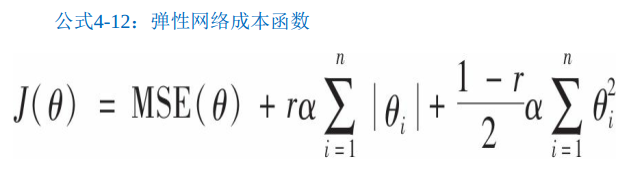

In [18]:
# 岭回归是个不错的默认选择， 但是如果你觉得实际用到的特征只有少数几个， 
# 那就应该更倾向于Lasso回归或是弹性网络， 因为它们会将无用特征的权重降为零。 
# 一般而言， 弹性网络优于Lasso回归， 
# 因为当特征数量超过训练实例数量， 又或者是几个特征强相关时， Lasso回归的表现可能非常不稳定

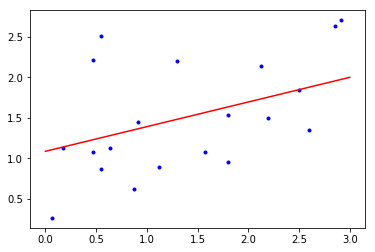

In [20]:
from sklearn.linear_model import ElasticNet

elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic_net.fit(x,y)
# elastic_net.predict([[1.5]])

y_pred = elastic_net.predict(x_new)

plt.plot(x,y,'b.')
plt.plot(x_new,y_pred,'r-')

**早期停止法**

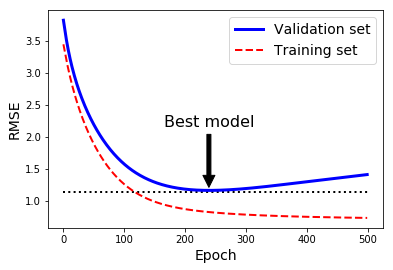

In [23]:
np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 2 + X + 0.5 * X**2 + np.random.randn(m, 1)

X_train, X_val, y_train, y_val = train_test_split(X[:50], y[:50].ravel(), test_size=0.5, random_state=10)

poly_scaler = Pipeline([
        ("poly_features", PolynomialFeatures(degree=90, include_bias=False)),
        ("std_scaler", StandardScaler()),
    ])

X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

sgd_reg = SGDRegressor(max_iter=1,
                       tol=-np.infty,
                       penalty=None,
                       eta0=0.0005,
                       warm_start=True,
                       learning_rate="constant",
                       random_state=42)

n_epochs = 500
train_errors, val_errors = [], []
for epoch in range(n_epochs):
    sgd_reg.fit(X_train_poly_scaled, y_train)
    y_train_predict = sgd_reg.predict(X_train_poly_scaled)
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    train_errors.append(mean_squared_error(y_train, y_train_predict))
    val_errors.append(mean_squared_error(y_val, y_val_predict))

best_epoch = np.argmin(val_errors)
best_val_rmse = np.sqrt(val_errors[best_epoch])

plt.annotate('Best model',
             xy=(best_epoch, best_val_rmse),
             xytext=(best_epoch, best_val_rmse + 1),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=16,
            )

best_val_rmse -= 0.03  # just to make the graph look better
plt.plot([0, n_epochs], [best_val_rmse, best_val_rmse], "k:", linewidth=2)
plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="Validation set")
plt.plot(np.sqrt(train_errors), "r--", linewidth=2, label="Training set")
plt.legend(loc="upper right", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("RMSE", fontsize=14)

plt.show()

In [26]:
from sklearn.base import clone

sgd_reg = SGDRegressor(max_iter=1, warm_start=True, penalty=None,learning_rate="constant", eta0=0.0005, random_state=42)

minimum_val_error = float('inf')
best_epoch = None
bes_model = None
for epoch in range(1000):
    sgd_reg.fit(X_train_poly_scaled, y_train) # continues where it left off
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    val_error = mean_squared_error(y_val_predict, y_val)
    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_epoch = epoch
        best_model = clone(sgd_reg)

C:\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol

C:\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol

C:\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol

In [27]:
best_epoch, best_model

(239,
 SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
        eta0=0.0005, fit_intercept=True, l1_ratio=0.15,
        learning_rate='constant', loss='squared_loss', max_iter=1,
        n_iter=None, n_iter_no_change=5, penalty=None, power_t=0.25,
        random_state=42, shuffle=True, tol=None, validation_fraction=0.1,
        verbose=0, warm_start=True))

**决策边缘**